# Explotation of proteomics data

The aim of this exercise is to visually divide samples by exposure. The main task here is to  find discriminating features. This is what machine learning is about. 

In [1]:
# First we load some libraries that we always need
# If you do not know what they are good for I suggest 
# three options:
# 1. Do not worry about this for now
# 2. Use google to find information
# 3. Ask somebody who might know
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First we locate the data files we are going to work with. This is a first major obstacle. If we need only one file it is easy, but for different reasons the data we wish to analyze can be spread around several files. This is the case here, so we need to do some work already at this stage. Unfortunately, this happens more often than not.

In [2]:
# Import tool used to walk throug the files
from os import walk
# In order to make the code cleaner it is often usefull
# to specify values in variables. Here we specify the file
# path, that is, the folder to fetch files from
path = '../rawdata/In vivo II proteomics/'
# Now we walk through all filenames in the specified folder
(_, _, filenames) = next(walk(path))
# We only keep the file ending with xlsx, that is, the excel files
filenames = [path + name for name in filenames if name.endswith('.xlsx')]

Here the excel files are on 'standard form', that is they are formatted to be visually pleasing. This makes them a little hard to read in because we have to discard empty columns. Moreover, the excel files are redundant. The control samples are present in all of them. We need to deal with this. You can avoid this hassle if you prepare a spreadsheet with exactly the information you need.

In [3]:
# Helper method for reading in multiple excel files and 
# formatting them for use in the analysis
def read_excel_files(filepaths, max_null_columns=None):
    '''
    Read in excel files. 
    '''
    # Force the filepaths to consist of a list of filepaths also
    # when a single filename is given as input
    if type(filepaths) == str:
        filepaths = [filepaths]
    # Read in the content of all spreadsheets
    datas = [pd.read_excel(io=filepath, index_col=0) for filepath
        in filepaths]
    # Format the individual spreadsheets
    for idx, df in enumerate(datas):
        # Discard empty columns
        df = df.dropna(how='all', axis=1)
        # Discard columns with no name
        df = df[df.index.notnull()]
        # Discard duplicate columns keeping biggest values.
        df_dup = df.loc[df.index.duplicated(keep=False)]
        df = df.loc[~df.index.duplicated(keep=False)]
        for name in np.unique(df_dup.index):
            df.loc[name] = df_dup.loc[name].max(axis=0).values
        datas[idx] = df
    # Merge all spreadsheets into one spreadsheet
    df = pd.concat(datas, axis=1, sort=False)
    # Discard duplicate columns
    df = df.loc[:,~df.columns.duplicated()]
    # Discard all rows with more than `max_null_columns` empty entries
    if max_null_columns is not None:
        df = df.loc[df.isnull().sum(axis=1) <= max_null_columns]
    # Fill in empty entries with columnwise minima
    mins = df.min()
    df = df.fillna(value=mins)
    # Return then resulting spreadsheet. We will call it a DataFrame from now on.
    return df

Now we read in the spreadsheets. 

In [4]:
df = read_excel_files(filenames, max_null_columns=0)

If you want to, you can inspect the content of the resulting DataFrame `df`. Since it clutters your screen I have commented the following cell out. You can activate it by seclecting it and changing its type to code. One way to do this is through the "Cell" option  on the top of this page.

We are going to work with the doses, so we need to extract them from the dataframe. This has been made a little difficult by the way the columns are named. This is unfortunately quitet realistic.

In [5]:
doses = np.array([name.split(',')[-1] for name in df.columns])

Next we flip (transpose) the dataframe (spreadsheet) and, for each gene id, calculate the mean values of the gene expressions with respect to dose.

In [6]:
df[df.columns] = np.arcsinh(df[df.columns].astype(float) / 5)

In [7]:
# Construct auxillary dataframes holding the flipped and averaged expressions
df2 = df.transpose()
df2['doses'] = doses
df2groups = df2.groupby('doses')
# Extract the averaged expressions in a numpy array
fit_values = df2groups.mean().values
# Clean up by deleting the auxillary dataframes
del df2
del df2groups

### Magic data manipulation. 

We first compute the first 5 principal directions of the gene ids with respect to the samples grouped into dosage. Then we use these principal directions to project the individual samples to 5 dimensional space. We store the result in the variable `X`.

In [8]:
# Import PCA module
from sklearn.decomposition import PCA
# Fit and transform PCA
pca = PCA(n_components=5).fit(fit_values)
print('explained_variance_ratio', np.cumsum(pca.explained_variance_ratio_))
X = pca.transform(df.values.transpose())

explained_variance_ratio [0.40813785 0.5859262  0.7147849  0.8057578  0.88710849]


### Visualization

For visualization we produce abbreviations of the dose names. We use a  helper function for this.

In [9]:
def short_dose_name(dose):
    words = dose.split()
    if words[-1][-1] in {'1', '2'}:
        return words[0][0] + words[-1][-1]
    else:
        return ''.join([word[0] for word in dose.split()])

We define a helper function for plotting. It takes several inputs.
* X is two-dimensional data that will be plotted by placing abbreviated dose names in the appropritat position on the plane
* y_text holds the dose abbreviations
* y_color specifies the colors. To begin with we want text and color to correspond.

In [10]:
from itertools import cycle, islice
def plot_embedding(X, y_text, y_color=None, title=None, colors=None):
    if y_color is None:
        y_color = y_text
    if colors is None:
        palette = np.vstack((plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(12))))
        palette = np.array(list(islice(cycle(palette), len(np.unique(y_color)))))
        colors = {}
        for idx, value in enumerate(np.unique(y_color)):
            colors[value] = palette[idx]
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    dimensions = x_max - x_min
    x_max = x_max + 0.1*dimensions
    x_min = x_min - 0.05*dimensions

    #plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_text[i]),
                 color=colors[y_color[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

We make a list of dosage abbreviations

In [11]:
y_dose = np.empty(len(doses), dtype=int)
for idx, dose in enumerate(np.unique(doses)):
    y_dose[np.array(doses) == dose] = idx

### Plot the data

First we plot the first two principal components

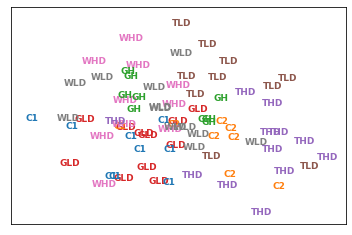

In [12]:
plot_embedding(X[:, [0, 1]], 
               [short_dose_name(dose) for dose in doses], 
               y_color=y_dose, colors=None)

And the second and third principal components

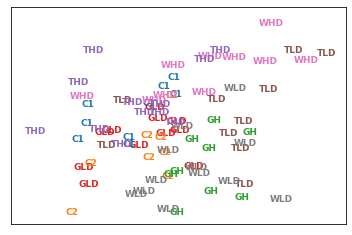

In [13]:
plot_embedding(X[:, [1,2]], 
               [short_dose_name(dose) for dose in doses], 
               y_color=y_dose, colors=None)

Next we compute a fancy embedding of the all principal components.

In [14]:
# Import UMAP module
from umap import UMAP
# Suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')
Y = UMAP(n_components=2).fit_transform(X)

And plot it

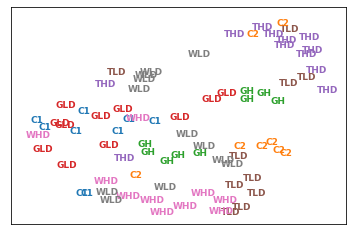

In [15]:
plot_embedding(Y, 
               [short_dose_name(dose) for dose in doses], 
               y_color=y_dose, colors=None)